In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

import os
for dirname, _, filenames in os.walk('/kaggle/input/riiid-test-answer-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train = pd.read_csv('riiid-test-answer-prediction/train.csv', nrows=10**4)
test = pd.read_csv("riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("riiid-test-answer-prediction/questions.csv")

In [3]:
'''
lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
part: top level category code for the lecture.
tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
type_of: brief description of the core purpose of the lecture
'''

'\nlecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).\npart: top level category code for the lecture.\ntag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.\ntype_of: brief description of the core purpose of the lecture\n'

In [4]:
# lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
# 각각의 강의번호 (train/test에 있는 content_id의 외래키)

lectures.lecture_id.nunique() # 418개의 강의

418

In [5]:
# part: top level category code for the lecture.
#part : 단원
lectures.part.unique()


array([5, 1, 6, 2, 7, 3, 4], dtype=int64)

In [6]:
lectures.part.value_counts() 

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [7]:
lectures.tag

0      159
1       70
2       45
3       79
4      156
      ... 
413      8
414    113
415     24
416    142
417     82
Name: tag, Length: 418, dtype: int64

In [8]:
# tag: one tag codes for the lecture. The meaning of the tags will not be provided, 
#      but these codes are sufficient for clustering the lectures together.
# 강의를 위한 코드 넘버링

lectures[lectures.tag==40]


,lecture_id,tag,part,type_of
202,16736,40,1,concept
215,17649,40,1,solving question


In [9]:
# type_of: brief description of the core purpose of the lecture

lectures.type_of.value_counts()


concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [10]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [11]:
print(f'There are {lectures.shape[0]} lecture_ids.')

There are 418 lecture_ids.


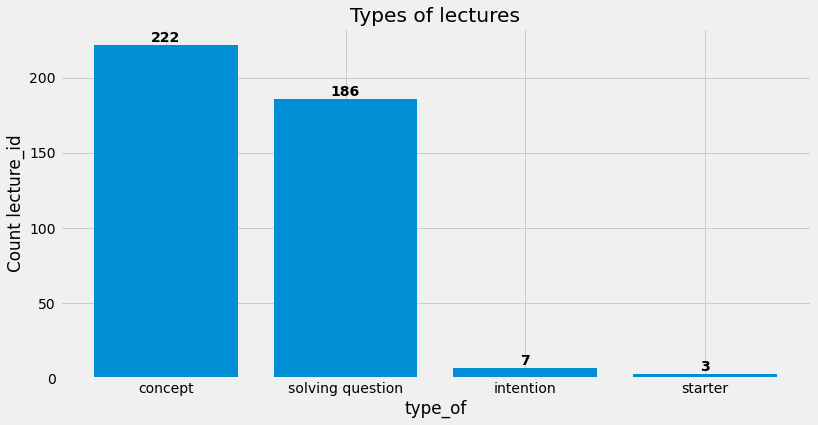

In [12]:
#강의 종류와 갯수 확인 (concept:222  solving question:86  intention:7  starter:3 )

lect_type_of = lectures.type_of.value_counts()

fig = plt.figure(figsize=(12,6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', fontsize=14, va='bottom', ha='center')
plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

answered_correctly     -1       0       1
user_id                                  
115                   NaN    14.0    32.0
124                   NaN    23.0     7.0
2746                  1.0     8.0    11.0
5382                  3.0    41.0    84.0
8623                  3.0    39.0    70.0
8701                  NaN     7.0    10.0
12741                 6.0   113.0   152.0
13134                 7.0   365.0   878.0
24418               181.0  1946.0  4337.0
24600                 NaN    33.0    17.0
32421                 NaN    16.0    14.0
40828                 1.0    34.0    58.0
44331                 3.0   120.0   171.0
45001                 NaN    23.0     7.0
46886                 1.0    17.0    27.0
50132                 NaN    28.0    46.0
51285                 NaN    10.0    12.0
53842                 NaN    23.0     7.0
81002                 NaN     8.0     9.0
81429                 NaN    16.0    14.0
91216                31.0   301.0   615.0
user_id
115        0
124        0


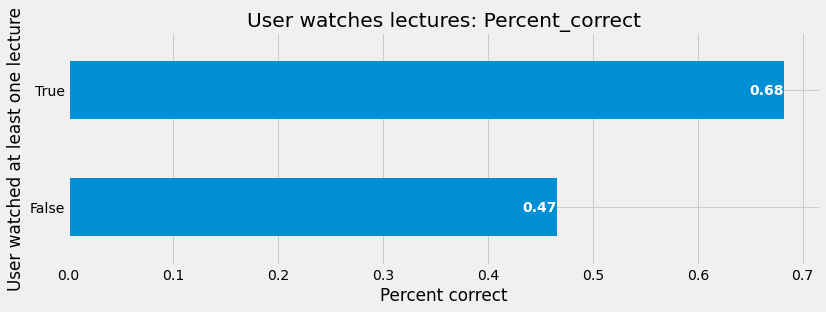

In [13]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
print(user_lect) # answered_correctly (-1, 0, 1)이 칼럼이 됨

user_lect.columns = ['Lecture', 'Wrong', 'Right'] #칼럼명 지정
user_lect['Lecture'] = user_lect['Lecture'].fillna(0) #-1값이 없는 사람(강의를 한번도 안들은 사람)은 값이 NaN이므로 0으로 채워줌
user_lect = user_lect.astype('Int64') #float -> int
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False) # user_lect.Lecture:강의를 들은 횟수 나타냄
                                        #user_lect.Lecture가 0보다 크면(강의를 1회 이상 들었으면) True, 아니면 False
                                #np.where(조건, 조건이 참일때 입력되는 값, 거짓일때 입력되는값)
print(user_lect.Lecture)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']}) #틀린문제, 맞은문제 sum
print(watches_l)

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)
                            #강의안들은사람, 들은사람 각각 맞은문제/전체문제 (맞은문제의비율) 구해서 새로운 칼럼(Percent_correct)으로 추가
print(watches_l['Percent_correct']) #False:0.572016   True:0.670602

watches_l = watches_l.iloc[:,2] #watches_l의 칼럼 Wrong, Right, Percent_correct 중에 Percent_correct 만 가져옴

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

In [36]:
train.task_container_id

0         1
1         2
2         0
3         3
4         4
       ... 
9995    775
9996    776
9997    777
9998    778
9999    779
Name: task_container_id, Length: 10000, dtype: int64

In [16]:
#추가 분석 필요

batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
print(batch_lect)

batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect['Percent_lecture'] = batch_lect.Lecture/(batch_lect.Lecture + batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect.sort_values(by = "Percent_lecture", ascending = False)

print(f'The highest number of lectures watched within a single task_container_id is {batch_lect.Lecture.max()}.')

answered_correctly  -1     0     1
task_container_id                 
0                  NaN   7.0  14.0
1                  NaN  15.0   6.0
2                  NaN  10.0  11.0
3                  NaN   8.0  13.0
4                  NaN  20.0  19.0
...                 ..   ...   ...
4885               NaN   1.0   NaN
4886               NaN   NaN   1.0
4887               NaN   NaN   1.0
4888               NaN   NaN   1.0
4889               NaN   NaN   1.0

[4890 rows x 3 columns]
The highest number of lectures watched within a single task_container_id is 2.


In [35]:
batch_lect = train.groupby(["task_container_id", "answered_correctly"]).size().unstack()
batch_lect

answered_correctly,-1,0,1
task_container_id,,,
0,NaN,7.0,14.0
1,NaN,15.0,6.0
2,NaN,10.0,11.0
3,NaN,8.0,13.0
4,NaN,20.0,19.0
...,...,...,...
4885,NaN,1.0,NaN
4886,NaN,NaN,1.0
4887,NaN,NaN,1.0


TypeError: float() argument must be a string or a number, not 'NAType'

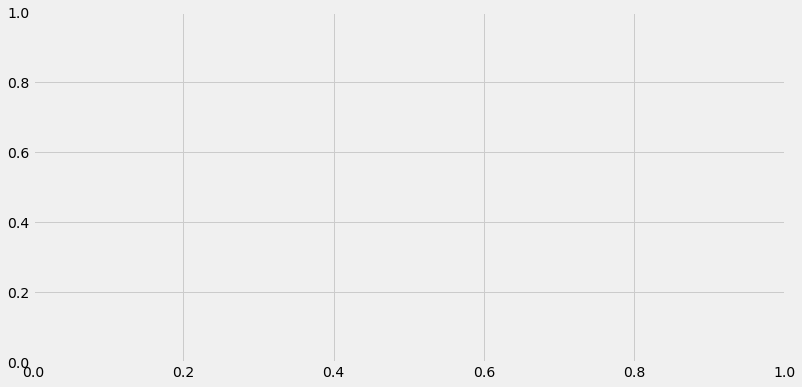

In [17]:
#추가 분석 필요
batch = batch_lect.iloc[:, 3:]

fig = plt.figure(figsize=(12,6))
x = batch.Percent_lecture
y = batch.Percent_correct
plt.scatter(x, y, marker='o')
plt.title("Percent lectures in a task_container versus percent answered correctly")
plt.xticks(rotation=0)
plt.xlabel("Percent lectures")
plt.ylabel("Percent answered correctly")

plt.show()

In [10]:
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f'We have {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids with lectures and {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids without lectures.')

We have 5979 task_container_ids with lectures and 4021 task_container_ids without lectures.


In [11]:
batch_lect = batch_lect[['Wrong', 'Right', 'Has_lecture']]
batch_lect = batch_lect.groupby("Has_lecture").sum()
batch_lect['Percent_correct'] = batch_lect.Right/(batch_lect.Wrong + batch_lect.Right)
batch_lect = batch_lect[['Percent_correct']]
batch_lect

,Percent_correct
Has_lecture,
False,0.735944
True,0.656856
